<a href="https://colab.research.google.com/github/excelasaph/Data-Preprocessing-Group-11/blob/main/Data_Merging_Product_Recommendation_Model_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Merge
### Merge `customer_social_profiles.csv` and `customer_transactions.csv` to create a dataset for the Product Recommendation Model, capturing relevant features.

### Import Libraries
#### Load necessary Python libraries for data manipulation, visualization, and scaling.

In [299]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
import joblib

### Load Datasets
#### Read the CSV files into pandas DataFrames.

In [300]:
social = pd.read_csv('/content/customer_social_profiles - customer_social_profiles.csv')
transactions = pd.read_csv('/content/customer_transactions - customer_transactions.csv')

In [301]:
print("Social Data Head:")
print(social.head())
print("\nTransactions Data Head:")
print(transactions.head())

Social Data Head:
  customer_id_new social_media_platform  engagement_score  \
0            A178              LinkedIn                74   
1            A190               Twitter                82   
2            A150              Facebook                96   
3            A162               Twitter                89   
4            A197               Twitter                92   

   purchase_interest_score review_sentiment  
0                      4.9         Positive  
1                      4.8          Neutral  
2                      1.6         Positive  
3                      2.6         Positive  
4                      2.3          Neutral  

Transactions Data Head:
   customer_id_legacy  transaction_id  purchase_amount purchase_date  \
0                 151            1001              408    2024-01-01   
1                 192            1002              332    2024-01-02   
2                 114            1003              442    2024-01-03   
3                 171     

### Exploratory Data Analysis (EDA)
#### Analyze data structure, statistics, and relationships (Exemplary requires summary stats, variable types, ≥3 labeled plots).

###### Summary Statistics:

In [302]:
print("Social Data Summary:")
print(social.describe(include='all'))
print("\nTransactions Data Summary:")
print(transactions.describe(include='all'))

Social Data Summary:
       customer_id_new social_media_platform  engagement_score  \
count              155                   155        155.000000   
unique              84                     5               NaN   
top               A155               Twitter               NaN   
freq                 7                    38               NaN   
mean               NaN                   NaN         75.606452   
std                NaN                   NaN         14.568021   
min                NaN                   NaN         50.000000   
25%                NaN                   NaN         63.500000   
50%                NaN                   NaN         77.000000   
75%                NaN                   NaN         87.500000   
max                NaN                   NaN         99.000000   

        purchase_interest_score review_sentiment  
count                155.000000              155  
unique                      NaN                3  
top                         NaN  

##### Distribution Plot (Engagement Score):

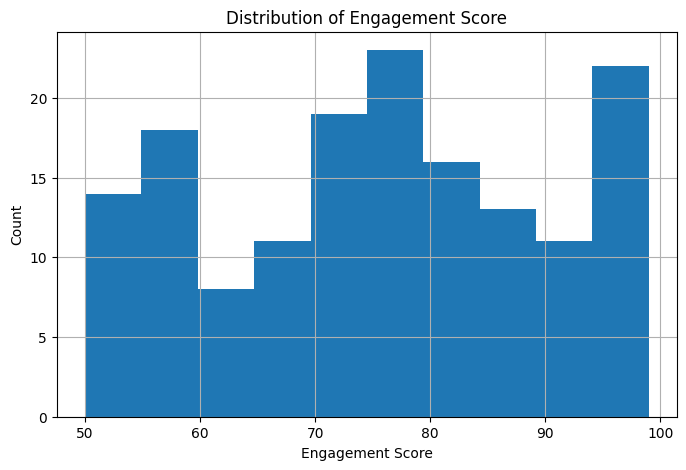

In [303]:
#Distribution of Engagement Score
plt.figure(figsize=(8, 5))
social['engagement_score'].hist(bins=10)
plt.title('Distribution of Engagement Score')
plt.xlabel('Engagement Score')
plt.ylabel('Count')
plt.show()

##### Outlier Plot (Purchase Amount):

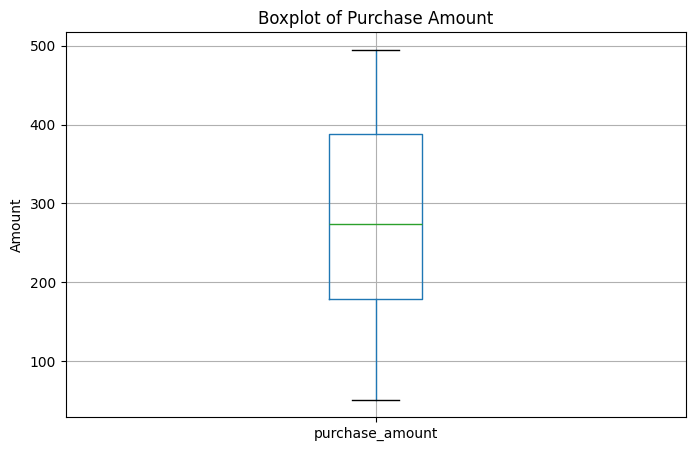

In [304]:
#Boxplot of Purchase Amount
plt.figure(figsize=(8, 5))
transactions.boxplot(column='purchase_amount')
plt.title('Boxplot of Purchase Amount')
plt.ylabel('Amount')
plt.show()

### Check for Missing Values and Duplicates
#### Identify data quality issues (Exemplary requires handling nulls/duplicates).

In [305]:
print("Social Missing Values:")
print(social.isnull().sum())
print("Transactions Missing Values:")
print(transactions.isnull().sum())
print(f"Social duplicates: {social.duplicated(subset=['customer_id_new']).sum()}")
print(f"Transactions duplicates: {transactions.duplicated(subset=['customer_id_legacy']).sum()}")

Social Missing Values:
customer_id_new            0
social_media_platform      0
engagement_score           0
purchase_interest_score    0
review_sentiment           0
dtype: int64
Transactions Missing Values:
customer_id_legacy     0
transaction_id         0
purchase_amount        0
purchase_date          0
product_category       0
customer_rating       10
dtype: int64
Social duplicates: 71
Transactions duplicates: 75


### Data Cleaning
#### Prepare datasets for merging by handling duplicates and nulls.

##### Deduplicate `social`

In [306]:
social_clean = social.groupby('customer_id_new').agg({
    'engagement_score': 'mean',
    'purchase_interest_score': 'mean',
    'review_sentiment': lambda x: x.mode()[0] if not x.mode().empty else x.iloc[0],
    'social_media_platform': lambda x: x.mode()[0] if not x.mode().empty else x.iloc[0]
}).reset_index()
print(f"Rows after deduplication: {len(social_clean)}")

Rows after deduplication: 84


##### Impute missing `customer_rating` in `transactions`

In [307]:
transactions['customer_rating'] = transactions['customer_rating'].fillna(transactions['customer_rating'].median())
print("Transactions Missing Values after Imputation:")
print(transactions.isnull().sum())

Transactions Missing Values after Imputation:
customer_id_legacy    0
transaction_id        0
purchase_amount       0
purchase_date         0
product_category      0
customer_rating       0
dtype: int64


##### Aggregate `transactions` duplicates

In [308]:
transactions_clean = transactions.groupby('customer_id_legacy').agg({
    'transaction_id': 'count',
    'purchase_amount': 'sum',
    'purchase_date': 'max',
    'product_category': lambda x: x.mode()[0] if not x.mode().empty else x.iloc[0],
    'customer_rating': 'mean'
}).reset_index().rename(columns={'transaction_id': 'transaction_count'})
print(f"Rows after aggregation: {len(transactions_clean)}")  # Should be 75

Rows after aggregation: 75


### Align Customer IDs
#### Match `customer_id_new` (e.g., A155) with `customer_id_legacy` (e.g., 155)

In [309]:
social_clean['customer_id'] = social_clean['customer_id_new'].str.replace('A', '').astype(int)
print("Customer ID Overlap Check:")
print(social_clean['customer_id'].isin(transactions_clean['customer_id_legacy']).value_counts())

Customer ID Overlap Check:
customer_id
True     61
False    23
Name: count, dtype: int64


### Merge Datasets
#### Combine datasets with a **left join** to retain all social profiles.

In [310]:
merged_data = pd.merge(social_clean, transactions_clean, left_on='customer_id', right_on='customer_id_legacy', how='left')
print(f"Rows in social_clean: {len(social_clean)}, Rows in merged_data: {len(merged_data)}")  # Should be 84

Rows in social_clean: 84, Rows in merged_data: 84


### Handle Null Values Post-Merge
#### Fill missing values from unmatched rows, addressing the **23 nulls** in `product_category`

In [311]:
merged_data['purchase_amount'] = merged_data['purchase_amount'].fillna(0)
merged_data['customer_rating'] = merged_data['customer_rating'].fillna(merged_data['customer_rating'].median())
merged_data['transaction_count'] = merged_data['transaction_count'].fillna(0)
merged_data['purchase_date'] = merged_data['purchase_date'].fillna('N/A')
# Impute product_category with 'Unknown' for unmatched rows
merged_data['product_category'] = merged_data['product_category'].fillna('Unknown')
print("Merged Data Missing Values after Initial Imputation:")
print(merged_data.isnull().sum())

Merged Data Missing Values after Initial Imputation:
customer_id_new             0
engagement_score            0
purchase_interest_score     0
review_sentiment            0
social_media_platform       0
customer_id                 0
customer_id_legacy         23
transaction_count           0
purchase_amount             0
purchase_date               0
product_category            0
customer_rating             0
dtype: int64


### Feature Engineering
#### Create and encode features for the model

In [312]:
merged_data['avg_purchase_per_transaction'] = merged_data['purchase_amount'] / merged_data['transaction_count'].replace(0, 1)
merged_data['avg_purchase_per_transaction'] = merged_data['avg_purchase_per_transaction'].fillna(0)

In [313]:
merged_data = pd.get_dummies(merged_data, columns=['review_sentiment', 'social_media_platform', 'product_category'])

In [314]:
merged_data = merged_data.drop(columns=['customer_id_legacy'])

##### Correlation Matrix (post-merge):

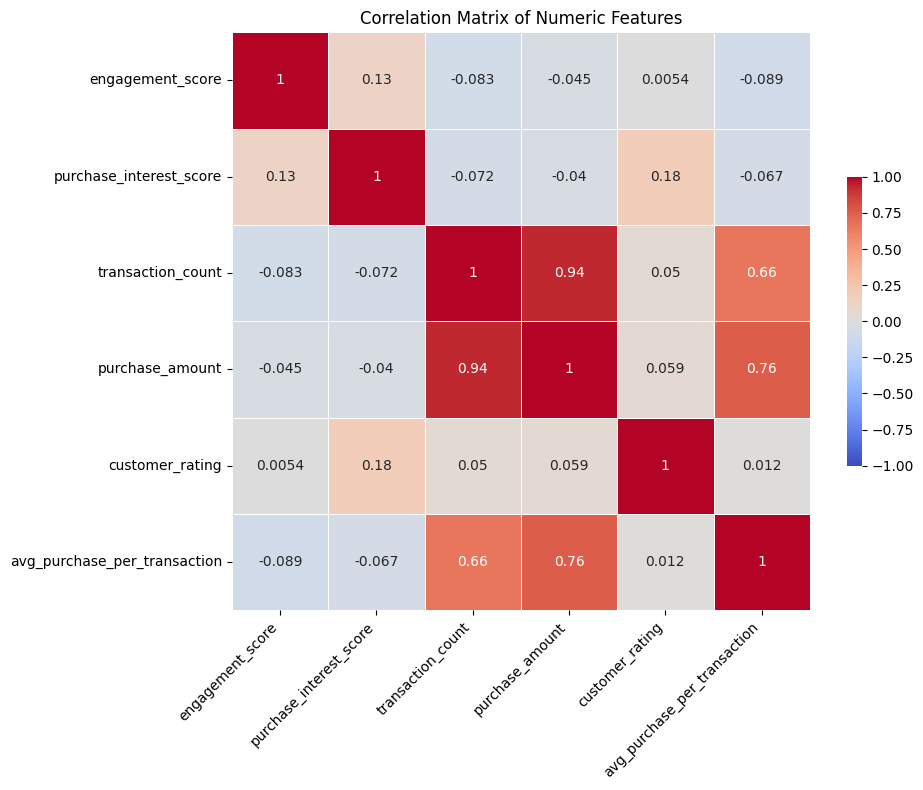

Correlation Matrix Values:
                              engagement_score  purchase_interest_score  \
engagement_score                      1.000000                 0.126234   
purchase_interest_score               0.126234                 1.000000   
transaction_count                    -0.083224                -0.071759   
purchase_amount                      -0.044885                -0.039919   
customer_rating                       0.005381                 0.180697   
avg_purchase_per_transaction         -0.088793                -0.066609   

                              transaction_count  purchase_amount  \
engagement_score                      -0.083224        -0.044885   
purchase_interest_score               -0.071759        -0.039919   
transaction_count                      1.000000         0.935674   
purchase_amount                        0.935674         1.000000   
customer_rating                        0.049957         0.058976   
avg_purchase_per_transaction           

In [315]:
numeric_cols = ['engagement_score', 'purchase_interest_score', 'transaction_count',
                'purchase_amount', 'customer_rating', 'avg_purchase_per_transaction']
correlation_matrix = merged_data[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .5})
plt.title('Correlation Matrix of Numeric Features')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("Correlation Matrix Values:")
print(correlation_matrix)

##### Convert `purchase_date` to numeric days:

In [316]:
def date_to_days(date_str):
    if date_str == 'N/A':
        return 0  # Unmatched rows
    date_obj = datetime.strptime(date_str, '%Y-%m-%d')
    ref_date = datetime(2024, 1, 1)
    return (date_obj - ref_date).days
merged_data['purchase_date_days'] = merged_data['purchase_date'].apply(date_to_days)
merged_data = merged_data.drop(columns=['purchase_date'])

##### Scale numeric columns:

In [317]:
scaler = MinMaxScaler()
numeric_cols = ['engagement_score', 'purchase_interest_score', 'purchase_amount',
                'customer_rating', 'avg_purchase_per_transaction', 'purchase_date_days']
merged_data[numeric_cols] = scaler.fit_transform(merged_data[numeric_cols])

##### Save Scaler

In [318]:
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

### Validation
#### Confirm data integrity

In [319]:
print("Final Merged Data Missing Values:")
print(merged_data.isnull().sum())
print("Number of Rows with purchase_amount == 0:")
print(merged_data[merged_data['purchase_amount'] == 0].shape[0])
print("Merged Data Description:")
print(merged_data.describe())

Final Merged Data Missing Values:
customer_id_new                    0
engagement_score                   0
purchase_interest_score            0
customer_id                        0
transaction_count                  0
purchase_amount                    0
customer_rating                    0
avg_purchase_per_transaction       0
review_sentiment_Negative          0
review_sentiment_Neutral           0
review_sentiment_Positive          0
social_media_platform_Facebook     0
social_media_platform_Instagram    0
social_media_platform_LinkedIn     0
social_media_platform_TikTok       0
social_media_platform_Twitter      0
product_category_Books             0
product_category_Clothing          0
product_category_Electronics       0
product_category_Groceries         0
product_category_Sports            0
product_category_Unknown           0
purchase_date_days                 0
dtype: int64
Number of Rows with purchase_amount == 0:
23
Merged Data Description:
       engagement_score  purchas

### Save Merged Data

In [320]:
merged_data.to_csv('merged_customer_data.csv', index=False)

In [321]:
merged_data.head()

,customer_id_new,engagement_score,purchase_interest_score,customer_id,transaction_count,purchase_amount,customer_rating,avg_purchase_per_transaction,review_sentiment_Negative,review_sentiment_Neutral,...,social_media_platform_LinkedIn,social_media_platform_TikTok,social_media_platform_Twitter,product_category_Books,product_category_Clothing,product_category_Electronics,product_category_Groceries,product_category_Sports,product_category_Unknown,purchase_date_days
0,A100,0.551020,0.871795,100,2.0,0.300054,0.820513,0.601075,True,False,...,False,False,False,True,False,False,False,False,False,0.979866
1,A101,0.367347,0.000000,101,4.0,0.545357,0.365385,0.546237,False,True,...,False,False,True,True,False,False,False,False,False,0.483221
2,A102,0.020408,0.974359,102,3.0,0.305421,0.598291,0.407885,False,True,...,True,False,False,False,False,True,False,False,False,0.973154
3,A103,0.292517,0.478632,103,3.0,0.427805,0.794872,0.571326,False,False,...,False,False,False,False,False,False,False,True,False,0.503356
4,A104,0.673469,0.495726,104,2.0,0.374665,0.089744,0.750538,True,False,...,False,False,True,False,True,False,False,False,False,0.986577


## Training the Product Recommendation Model

### Split the data

#### Split the `merged_data` into training and testing sets *before* separating based on `product_category_Unknown`.


#### Drop the specified columns to create the feature set `X` and create the target variable `y`.



In [322]:
X = merged_data.drop(columns=['customer_id_new', 'customer_id'] +
                     [col for col in merged_data.columns if col.startswith('product_category')])
y = merged_data[[col for col in merged_data.columns if col.startswith('product_category') and col != 'product_category_Unknown']].idxmax(axis=1)

print(X)
print(y)

    engagement_score  purchase_interest_score  transaction_count  \
0           0.551020                 0.871795                2.0   
1           0.367347                 0.000000                4.0   
2           0.020408                 0.974359                3.0   
3           0.292517                 0.478632                3.0   
4           0.673469                 0.495726                2.0   
..               ...                      ...                ...   
79          0.693878                 0.692308                0.0   
80          0.714286                 0.743590                0.0   
81          0.500000                 0.410256                0.0   
82          0.591837                 0.525641                2.0   
83          0.142857                 0.205128                2.0   

    purchase_amount  customer_rating  avg_purchase_per_transaction  \
0          0.300054         0.820513                      0.601075   
1          0.545357         0.365385       

#### Split the features and target into training and testing sets using `train_test_split`



In [323]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"New X_train shape: {X_train.shape}, New X_test shape: {X_test.shape}")
print(f"New y_train shape: {y_train.shape}, New y_test shape: {y_test.shape}")

New X_train shape: (67, 15), New X_test shape: (17, 15)
New y_train shape: (67,), New y_test shape: (17,)


### Hyperparameter Tuning

#### Define the parameter grid for hyperparameter tuning and perform `GridSearchCV`

In [324]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1)

# Perform GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the best score
print("Best hyperparameters found:")
print(grid_search.best_params_)
print(f"Best cross-validation accuracy: {grid_search.best_score_:.2f}")

Best hyperparameters found:
{'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation accuracy: 0.55


#### Train a new `RandomForestClassifier` model using the best hyperparameters found by `GridSearchCV` and evaluate its performance on the testing set

In [325]:
# Train the model with the best hyperparameters
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=2, n_estimators=300, random_state=42)

In [326]:
# Evaluate the tuned model on the testing set
y_test_pred_tuned = best_model.predict(X_test)

print(f"Tuned Model Validation Accuracy: {accuracy_score(y_test, y_test_pred_tuned):.2f}")
print(f"Tuned Model Validation F1-Score (weighted): {f1_score(y_test, y_test_pred_tuned, average='weighted'):.2f}")

Tuned Model Validation Accuracy: 0.65
Tuned Model Validation F1-Score (weighted): 0.61


### Predict on unknown data

#### Use the trained model to predict `product_category` for the data where it was originally 'Unknown'

In [327]:
unknown_category_data = merged_data[merged_data['product_category_Unknown'] == True].copy()
X_unknown = unknown_category_data.drop(columns=['customer_id_new', 'customer_id'] +
                                       [col for col in unknown_category_data.columns if col.startswith('product_category')])
predicted_categories = best_model.predict(X_unknown)
unknown_category_data['predicted_product_category'] = predicted_categories
display(unknown_category_data[['customer_id_new', 'predicted_product_category']])

,customer_id_new,predicted_product_category
8,A109,product_category_Books
10,A112,product_category_Books
13,A115,product_category_Books
14,A116,product_category_Books
16,A118,product_category_Books
20,A124,product_category_Books
22,A126,product_category_Books
26,A131,product_category_Books
35,A142,product_category_Books
38,A145,product_category_Books


### Feature Importance

In [328]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)
print("Feature Importance:")
print(feature_importance)

Feature Importance:
                            feature  importance
3                   purchase_amount    0.170852
14               purchase_date_days    0.151617
5      avg_purchase_per_transaction    0.150492
1           purchase_interest_score    0.110184
2                 transaction_count    0.103354
4                   customer_rating    0.101715
0                  engagement_score    0.085696
10  social_media_platform_Instagram    0.019299
7          review_sentiment_Neutral    0.018533
11   social_media_platform_LinkedIn    0.018422
13    social_media_platform_Twitter    0.017265
9    social_media_platform_Facebook    0.017118
8         review_sentiment_Positive    0.014524
6         review_sentiment_Negative    0.014005
12     social_media_platform_TikTok    0.006924


### Save Model

In [329]:
# Save Model
joblib.dump(best_model, 'product_recommendation_model.pkl')

['product_recommendation_model.pkl']

### Predict on New Sample Data

#### Create a sample new data point and predict its product category using the trained model.

In [330]:
new_customer_data = {
    'engagement_score': [80],
    'purchase_interest_score': [4.5],
    'transaction_count': [3],
    'purchase_amount': [100],
    'customer_rating': [4.0],
    'avg_purchase_per_transaction': [116.67],
    'review_sentiment_Negative': [True],
    'review_sentiment_Neutral': [False],
    'review_sentiment_Positive': [True],
    'social_media_platform_Facebook': [True],
    'social_media_platform_Instagram': [False],
    'social_media_platform_LinkedIn': [False],
    'social_media_platform_TikTok': [True],
    'social_media_platform_Twitter': [False],
    'purchase_date_days': [100]
}

new_customer_df = pd.DataFrame(new_customer_data)

# Scale the numeric columns using the same scaler fitted on the training data
numeric_cols_new = ['engagement_score', 'purchase_interest_score', 'purchase_amount',
                'customer_rating', 'avg_purchase_per_transaction', 'purchase_date_days']

new_customer_df[numeric_cols_new] = scaler.transform(new_customer_df[numeric_cols_new])

# Reindex the new data to match the columns of X_train and fill missing columns with 0
new_customer_df = new_customer_df.reindex(columns=X_train.columns, fill_value=0)

# Predict the product category for the new customer
predicted_category_new = best_model.predict(new_customer_df)

print(f"Predicted product category for the new customer: {predicted_category_new[0]}")

Predicted product category for the new customer: product_category_Electronics


### Predict on a Real Data Point

#### Randomly select a row from the `merged_data`, prepare it for prediction, and compare the prediction to the actual product category

In [331]:
random_index = merged_data.sample(n=1).index[0]
real_customer_data = merged_data.loc[[random_index]].copy()

actual_product_category = y.loc[random_index]

real_customer_features = real_customer_data.drop(columns=['customer_id_new', 'customer_id'] +
                                       [col for col in merged_data.columns if col.startswith('product_category')])

real_customer_features = real_customer_features.reindex(columns=X_train.columns, fill_value=0)

# Predict the product category for the real customer data
predicted_category_real = best_model.predict(real_customer_features)

print(f"Actual product category for the selected row: {actual_product_category}")
print(f"Predicted product category for the selected row: {predicted_category_real[0]}")

Actual product category for the selected row: product_category_Books
Predicted product category for the selected row: product_category_Books
